In [1]:
from ast import Index

import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt
from sqlglot import column

bank_df = pd.read_csv('icea_bank.xlsx - bank_recon.csv')
cash_book = pd.read_csv('icea_cashbook.xlsx - cash_book_recon.csv')


In [2]:
## Filter out charges from bank
bank_df_ncba = bank_df[bank_df['is_charge'] == False]
bank_df = bank_df[bank_df['is_charge'] == False]

## Drop duplicates
cash_book = cash_book.drop_duplicates()
bank_df_ncba = bank_df_ncba.drop_duplicates()


In [3]:
# Create the new columns in bank by combining the values from the specified columns
bank_df_ncba.loc[:, 'trx_id'] = bank_df_ncba[['ft_no', 'tt_no', 'aaa_no', 'md_no']].bfill(axis=1).iloc[:, 0]
bank_df_ncba.loc[:, 'trx_id2'] = bank_df_ncba[['charge_id', 'batch_no','bulk_trans_id','inhouse_cheque_no','cheque_no']].bfill(axis=1).iloc[:, 0]

#bank_df_ncba

In [4]:
## Extract policy no from bank
def extract_and_remove_patterns(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    # Define the patterns to be extracted
    patterns = [
        r"\d{3}/[A-Za-z]{3}/\d+",  # e.g., "123/ABC/456"
        r"\d{3}/[A-Za-z]{3}\d+",   # e.g., "123/ABC456"
        r"\d{3}[A-Za-z]{3}/\d+",   # e.g., "123ABC/456"
        r"\d{3}[A-Za-z]{3}\d+",    # e.g., "123ABC456"
        r"\d{3}[A-Za-z]{3} \d+",   # e.g., "123ABC 456"
        r"\d{3} [A-Za-z]{3}\d+",   # e.g., "123 ABC456"
        r"\d{3} [A-Za-z]{3} \d+",  # e.g., "123 ABC 456"
        r"\d{3}/'NCBAEDU/\d+" ,   # e.g., "123/'NCBAEDU'/456"
        r"\d{3}/NCBAEDU\d+",     # e.g., "123/'NCBAEDU'456"
        r"\d{3}NCBAEDU\d+",      # e.g., "123'NCBAEDU'/456"
        r"\d{3} NCBAEDU \d+"    # e.g., "123 'NCBAEDU' 456"
        ]


      # Combine the patterns into a single regex with alternation
    combined_pattern = "|".join(patterns)

    # Function to extract the pattern and remove it from the original text
    def extract_pattern(text):
        match = re.search(combined_pattern, text, re.IGNORECASE)  # Case-insensitive search
        if match:
            extracted = match.group()
            cleaned_text = re.sub(combined_pattern, "", text, flags=re.IGNORECASE).strip()  # Case-insensitive removal
            return extracted, cleaned_text
        return None, text

    # Apply the extraction and removal function
    df[['policy_no', column_name]] = df[column_name].apply(
        lambda x: pd.Series(extract_pattern(str(x)))
    )

    return df

bank_df_ncba = extract_and_remove_patterns(bank_df_ncba, 'transaction_details_2')


### Exploratory analysis

In [5]:
# sort index
cash_book = cash_book.rename(columns={"index_cb":"unique_id"})
bank_df_ncba = bank_df_ncba.rename(columns={"index_bank":"unique_id"})

bank_df_ncba.columns

Index(['unique_id', 'date', 'transaction_details_1', 'transaction_details_2',
       'amount', 'trx_type', 'trans_type', 'trx_detail', 'period', 'ft_no',
       'tt_no', 'aaa_no', 'md_no', 'charge_id', 'batch_no',
       'inhouse_cheque_no', 'cheque_no', 'bulk_trans_id', 'is_charge',
       'trx_id', 'trx_id2', 'policy_no'],
      dtype='object')

### Blocking

In [6]:
from splink import DuckDBAPI, block_on
from splink.blocking_analysis import n_largest_blocks

from splink.blocking_analysis import count_comparisons_from_blocking_rule
db_api = DuckDBAPI()

from splink.blocking_analysis import (
    cumulative_comparisons_to_be_scored_from_blocking_rules_chart,
)

## Rename cols to common names
cash_book = cash_book.rename(columns={"posting_date":"date"})
cash_book = cash_book.rename(columns={"eft_file_name_1":"eft1","eft_file_name_2":"eft2"})
bank_df_ncba = bank_df_ncba.rename(columns={"trx_id":"eft1","trx_id2":"eft2",})


columns_to_keep = ['unique_id','date','amount','eft1','eft2','policy_no','trx_type']

# Drop all columns except those in `columns_to_keep`
bank_df_ncba= bank_df_ncba.drop(columns=[col for col in bank_df_ncba.columns if col not in columns_to_keep])
cash_book= cash_book.drop(columns=[col for col in cash_book.columns if col not in columns_to_keep])



In [7]:
from jellyfish import levenshtein_distance # Import levenshtein_distance

from splink.blocking_analysis import (
    cumulative_comparisons_to_be_scored_from_blocking_rules_chart,
)

blocking_rules_for_analysis = [
    block_on("eft1","amount"),
    block_on("eft2","amount"),
    block_on("trx_type","date"),
    block_on("date"),
    block_on("amount")
]


cumulative_comparisons_to_be_scored_from_blocking_rules_chart(
    table_or_tables=[bank_df_ncba,cash_book],
    blocking_rules=blocking_rules_for_analysis,
    db_api=db_api,
    link_type="link_only",
)

alt.Chart(...)

In [8]:
from splink.exploratory import completeness_chart

completeness_chart(
    [bank_df_ncba, cash_book],
    cols=["eft1", "eft2", "trx_type", "amount", "date"],
    db_api=DuckDBAPI(),
    table_names_for_chart=["bank", "cashbook"],
)

alt.LayerChart(...)

### Estimating model parameters

In [9]:
from splink import Linker, SettingsCreator, block_on, DuckDBAPI
import splink.comparison_library as cl

settings = SettingsCreator(
    unique_id_column_name="unique_id",
    link_type="link_only",
    comparisons=[
        cl.NameComparison("date").configure(term_frequency_adjustments=True),
        cl.NameComparison("policy_no").configure(term_frequency_adjustments=True),
        cl.NameComparison("eft1"),
        cl.NameComparison("eft2"),
        cl.NameComparison("trx_type").configure(term_frequency_adjustments=True),
        cl.ExactMatch("amount")  
    ],
    retain_intermediate_calculation_columns=True,
)
linker = Linker([bank_df_ncba,cash_book],settings,db_api=DuckDBAPI())

In [10]:
## estimate records match
deterministic_rules = [
    block_on("eft1","amount"),
    block_on("policy_no"),
    block_on("amount","eft2"),
    block_on("date")
]
linker.training.estimate_probability_two_random_records_match(deterministic_rules, recall=0.7)

Probability two random records match is estimated to be  0.0618.
This means that amongst all possible pairwise record comparisons, one in 16.19 are expected to match.  With 49,314,207 total possible comparisons, we expect a total of around 3,046,614.29 matching pairs


In [11]:
## estimate u probabilities
linker.training.estimate_u_using_random_sampling(max_pairs=1e8)


----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

u probability not trained for date - Jaro-Winkler distance of date >= 0.88 (comparison vector value: 2). This usually means the comparison level was never observed in the training data.
u probability not trained for date - Jaro-Winkler distance of date >= 0.7 (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
u probability not trained for date - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.
u probability not trained for trx_type - Exact match on trx_type (comparison vector value: 4). This usually means the comparison level was never observed in the training data.
u probability not trained for trx_type - Jaro-Winkler distance of trx_type >= 0.92 (comparison vector value: 3). This usually means the comparison level was never observed in the training data.
u probability not trained for trx_type - Jaro-Winkler distance of trx_type >= 0.88 (compa

In [12]:
## estimate m probabilities

# first pass
training_block_rule = block_on("eft1","amount")
training_session_dob =(
    linker.training.estimate_parameters_using_expectation_maximisation(training_block_rule)
)



----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
(l."eft1" = r."eft1") AND (l."amount" = r."amount")

Parameter estimates will be made for the following comparison(s):
    - date
    - policy_no
    - eft2
    - trx_type

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - eft1
    - amount

Level Jaro-Winkler distance of date >= 0.88 on comparison date not observed in dataset, unable to train m value

Level Jaro-Winkler distance of date >= 0.7 on comparison date not observed in dataset, unable to train m value

Level All other comparisons on comparison date not observed in dataset, unable to train m value

Level Exact match on eft2 on comparison eft2 not observed in dataset, unable to train m value

Level Jaro-Winkler distance of eft2 >= 0.92 on comparison eft2 not observed in dataset, unable to train m value

Level Jaro-Winkler distance of eft2 >= 0.88 on comparison 

In [13]:
# second pass
training_block_rule = block_on("eft2","amount")
training_session_fname_sname =(
    linker.training.estimate_parameters_using_expectation_maximisation(training_block_rule)
)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
(l."eft2" = r."eft2") AND (l."amount" = r."amount")

Parameter estimates will be made for the following comparison(s):
    - date
    - policy_no
    - eft1
    - trx_type

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - eft2
    - amount

Level Jaro-Winkler distance of date >= 0.88 on comparison date not observed in dataset, unable to train m value

Level Jaro-Winkler distance of date >= 0.7 on comparison date not observed in dataset, unable to train m value

Level All other comparisons on comparison date not observed in dataset, unable to train m value

Level Exact match on policy_no on comparison policy_no not observed in dataset, unable to train m value

Level Jaro-Winkler distance of policy_no >= 0.92 on comparison policy_no not observed in dataset, unable to train m value

Level Jaro-Winkler distance of policy_

In [14]:
# Third pass
training_block_rule = block_on("policy_no")
training_session_policy =(
    linker.training.estimate_parameters_using_expectation_maximisation(training_block_rule)
)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l."policy_no" = r."policy_no"

Parameter estimates will be made for the following comparison(s):
    - date
    - eft1
    - eft2
    - trx_type
    - amount

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - policy_no

Level Jaro-Winkler distance of date >= 0.88 on comparison date not observed in dataset, unable to train m value

Level Jaro-Winkler distance of date >= 0.7 on comparison date not observed in dataset, unable to train m value

Level All other comparisons on comparison date not observed in dataset, unable to train m value

Level Exact match on eft2 on comparison eft2 not observed in dataset, unable to train m value

Level Jaro-Winkler distance of eft2 >= 0.88 on comparison eft2 not observed in dataset, unable to train m value

Level Exact match on trx_type on comparison trx_type not observed in dataset, un

In [15]:
# Fourth pass
training_block_rule = block_on("date")
training_session_date =(
    linker.training.estimate_parameters_using_expectation_maximisation(training_block_rule)
)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l."date" = r."date"

Parameter estimates will be made for the following comparison(s):
    - policy_no
    - eft1
    - eft2
    - trx_type
    - amount

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - date

Level Exact match on trx_type on comparison trx_type not observed in dataset, unable to train m value

Level Jaro-Winkler distance of trx_type >= 0.92 on comparison trx_type not observed in dataset, unable to train m value

Level Jaro-Winkler distance of trx_type >= 0.88 on comparison trx_type not observed in dataset, unable to train m value

Iteration 1: Largest change in params was -0.95 in the m_probability of trx_type, level `Exact match on trx_type`
Iteration 2: Largest change in params was -0.12 in the m_probability of eft1, level `All other comparisons`
Iteration 3: Largest change in params was -0.0903 in 

In [16]:
df_predictions = linker.inference.predict(threshold_match_probability=0.5)
df_predictions.as_pandas_dataframe(limit=5)

# threshold = 0.5 to ensure match weight is > 0

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Blocking time: 16.10 seconds


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Predict time: 237.11 seconds

 -- WARNING --
You have called predict(), but there are some parameter estimates which have neither been estimated or specified in your settings dictionary.  To produce predictions the following untrained trained parameters will use default values.
Comparison: 'date':
    m values not fully trained
Comparison: 'date':
    u values not fully trained
Comparison: 'trx_type':
    m values not fully trained
Comparison: 'trx_type':
    u values not fully trained


,match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,date_l,date_r,gamma_date,tf_date_l,...,trx_type_r,gamma_trx_type,tf_trx_type_l,tf_trx_type_r,bf_trx_type,bf_tf_adj_trx_type,amount_l,amount_r,gamma_amount,bf_amount
0,0.34801,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1344,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.0,1,58.457106
1,0.34801,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1364,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.0,1,58.457106
2,0.34801,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1365,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.0,1,58.457106
3,0.34801,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1367,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.0,1,58.457106
4,0.34801,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1386,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.0,1,58.457106


In [17]:
df_predictions.as_pandas_dataframe()


,match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,date_l,date_r,gamma_date,tf_date_l,...,trx_type_r,gamma_trx_type,tf_trx_type_l,tf_trx_type_r,bf_trx_type,bf_tf_adj_trx_type,amount_l,amount_r,gamma_amount,bf_amount
0,0.348010,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1344,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.00,1,58.457106
1,0.348010,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1364,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.00,1,58.457106
2,0.348010,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1365,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.00,1,58.457106
3,0.348010,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1367,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.00,1,58.457106
4,0.348010,0.560015,__splink__input_table_0,__splink__input_table_1,2620,1386,2023-11-28 00:00:00,2023-11-01 00:00:00,3,0.113042,...,receipt,1,0.070286,0.860633,1.069391,1.0,200.0,200.00,1,58.457106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314925,0.500697,0.585904,__splink__input_table_0,__splink__input_table_1,3150,20684,2023-11-30 00:00:00,2023-11-30 00:00:00,4,0.133302,...,receipt,1,0.070286,0.860633,1.069391,1.0,2506.0,2857.60,0,0.744737
314926,0.500697,0.585904,__splink__input_table_0,__splink__input_table_1,3150,20722,2023-11-30 00:00:00,2023-11-30 00:00:00,4,0.133302,...,receipt,1,0.070286,0.860633,1.069391,1.0,2506.0,2857.60,0,0.744737
314927,0.500697,0.585904,__splink__input_table_0,__splink__input_table_1,3150,20772,2023-11-30 00:00:00,2023-11-30 00:00:00,4,0.133302,...,receipt,1,0.070286,0.860633,1.069391,1.0,2506.0,10165.00,0,0.744737
314928,0.500697,0.585904,__splink__input_table_0,__splink__input_table_1,3150,20778,2023-11-30 00:00:00,2023-11-30 00:00:00,4,0.133302,...,receipt,1,0.070286,0.860633,1.069391,1.0,2506.0,1904.75,0,0.744737


In [ ]:
## Waterfall chart
records_to_view = df_predictions.as_record_dict(limit=50)
linker.visualisations.waterfall_chart(records_to_view, filter_nulls=False)


In [18]:
match_predictions = df_predictions.as_pandas_dataframe()
match_predictions.columns

Index(['match_weight', 'match_probability', 'source_dataset_l',
       'source_dataset_r', 'unique_id_l', 'unique_id_r', 'date_l', 'date_r',
       'gamma_date', 'tf_date_l', 'tf_date_r', 'bf_date', 'bf_tf_adj_date',
       'policy_no_l', 'policy_no_r', 'gamma_policy_no', 'tf_policy_no_l',
       'tf_policy_no_r', 'bf_policy_no', 'bf_tf_adj_policy_no', 'eft1_l',
       'eft1_r', 'gamma_eft1', 'tf_eft1_l', 'tf_eft1_r', 'bf_eft1',
       'bf_tf_adj_eft1', 'eft2_l', 'eft2_r', 'gamma_eft2', 'tf_eft2_l',
       'tf_eft2_r', 'bf_eft2', 'bf_tf_adj_eft2', 'trx_type_l', 'trx_type_r',
       'gamma_trx_type', 'tf_trx_type_l', 'tf_trx_type_r', 'bf_trx_type',
       'bf_tf_adj_trx_type', 'amount_l', 'amount_r', 'gamma_amount',
       'bf_amount'],
      dtype='object')

In [19]:
bank_df.columns

Index(['index_bank', 'date', 'transaction_details_1', 'transaction_details_2',
       'amount', 'trx_type', 'trans_type', 'trx_detail', 'period', 'ft_no',
       'tt_no', 'aaa_no', 'md_no', 'charge_id', 'batch_no',
       'inhouse_cheque_no', 'cheque_no', 'bulk_trans_id', 'is_charge'],
      dtype='object')

In [20]:
match_predictions=match_predictions[['match_weight', 'match_probability', 'source_dataset_l',
       'source_dataset_r', 'unique_id_l', 'unique_id_r', 'date_l', 'date_r',
       'tf_date_l', 'tf_date_r',  
       'policy_no_l', 'policy_no_r',  'tf_policy_no_l',
       'tf_policy_no_r', 'bf_policy_no',  'eft1_l',
       'eft1_r',  'tf_eft1_l', 'tf_eft1_r', 'bf_eft1',
        'eft2_l', 'eft2_r',  'tf_eft2_l',
       'tf_eft2_r', 'bf_eft2', 'trx_type_l', 'trx_type_r',
        'amount_l', 'amount_r',
       'bf_amount']]

In [21]:
#bank_df=bank_df[['index_bank','date','amount','match_weight']]

bank_df_merged = bank_df.merge(match_predictions, how='left',left_on='index_bank',right_on='unique_id_l')
bank_df_merged.columns
bank_df_merged

,index_bank,date,transaction_details_1,transaction_details_2,amount,trx_type,trans_type,trx_detail,period,ft_no,...,eft2_l,eft2_r,tf_eft2_l,tf_eft2_r,bf_eft2,trx_type_l,trx_type_r,amount_l,amount_r,bf_amount
0,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,None,FA OCT 2023,NaN,0.094171,1.000000,credit,receipt,2206.0,2206.00,58.457106
1,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,None,FT23307KK5R8,NaN,0.006364,1.000000,credit,receipt,2206.0,6135.00,0.744737
2,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,None,FT23307KK5R8,NaN,0.006364,1.000000,credit,receipt,2206.0,10025.00,0.744737
3,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,None,FT23310MT005,NaN,0.042243,1.000000,credit,receipt,2206.0,3509.00,0.744737
4,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,None,FA OCT 2023,NaN,0.094171,1.000000,credit,receipt,2206.0,2206.00,58.457106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314963,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,645.0,FT23334T3KVN,0.000046,0.007886,1.018999,credit,receipt,10000.0,10165.00,0.744737
314964,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,645.0,FT23334T3KVN,0.000046,0.007886,1.018999,credit,receipt,10000.0,1904.75,0.744737
314965,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,645.0,FT23334T3KVN,0.000046,0.007886,1.018999,credit,receipt,10000.0,5714.25,0.744737
314966,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,645.0,FT23334T3KVN,0.000046,0.007886,1.018999,credit,receipt,10000.0,2666.65,0.744737


In [22]:
# showing the matches where match weight is +ve
bank_df_merged['matched'] = bank_df_merged['match_weight'] > 0.95
bank_df_merged

,index_bank,date,transaction_details_1,transaction_details_2,amount,trx_type,trans_type,trx_detail,period,ft_no,...,eft2_r,tf_eft2_l,tf_eft2_r,bf_eft2,trx_type_l,trx_type_r,amount_l,amount_r,bf_amount,matched
0,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,FA OCT 2023,NaN,0.094171,1.000000,credit,receipt,2206.0,2206.00,58.457106,False
1,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,FT23307KK5R8,NaN,0.006364,1.000000,credit,receipt,2206.0,6135.00,0.744737,False
2,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,FT23307KK5R8,NaN,0.006364,1.000000,credit,receipt,2206.0,10025.00,0.744737,False
3,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,FT23310MT005,NaN,0.042243,1.000000,credit,receipt,2206.0,3509.00,0.744737,False
4,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,FA OCT 2023,NaN,0.094171,1.000000,credit,receipt,2206.0,2206.00,58.457106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314963,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,FT23334T3KVN,0.000046,0.007886,1.018999,credit,receipt,10000.0,10165.00,0.744737,False
314964,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,FT23334T3KVN,0.000046,0.007886,1.018999,credit,receipt,10000.0,1904.75,0.744737,False
314965,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,FT23334T3KVN,0.000046,0.007886,1.018999,credit,receipt,10000.0,5714.25,0.744737,False
314966,3168,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000645 PRESTIGE FT23334T4VS8,10000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000645 PRESTIGE FT233...,2023Q4,FT23334T4VS8,...,FT23334T3KVN,0.000046,0.007886,1.018999,credit,receipt,10000.0,2666.65,0.744737,False


In [23]:
# Drop rows where 'index_bank' or 'match_probability' are NaN
cleaned_df = bank_df_merged.dropna(subset=['index_bank', 'match_probability'])

# Find the index of the row with the highest match_probability for each index_bank
idx = cleaned_df.groupby('index_bank')['match_probability'].idxmax()

# Use these indices to select the rows with the highest match_probability
filtered_df = cleaned_df.loc[idx]
filtered_df

,index_bank,date,transaction_details_1,transaction_details_2,amount,trx_type,trans_type,trx_detail,period,ft_no,...,eft2_r,tf_eft2_l,tf_eft2_r,bf_eft2,trx_type_l,trx_type_r,amount_l,amount_r,bf_amount,matched
5,0,2023-11-01 00:00:00,Standing Order FT233054RNZQ,POLICY PREMIUM 029/VES/155738 EUNICE KAMBA MBU...,2206.00,credit,Standing Order,Standing Order FT233054RNZQ POLICY PREMIUM 029...,2023Q4,FT233054RNZQ,...,FT233054RNZQ,NaN,0.000046,1.000000,credit,receipt,2206.00,2206.0,58.457106,True
26,1,2023-11-01 00:00:00,Standing Order FT23305LCPC5,093715/093716/143362/171223 MARTIN KIMANI KANG...,8020.00,credit,Standing Order,Standing Order FT23305LCPC5 093715/093716/1433...,2023Q4,FT23305LCPC5,...,FT23305LCPC5,NaN,0.000184,1.000000,credit,receipt,8020.00,2005.0,0.744737,True
74,2,2023-11-01 00:00:00,Standing Order FT23305RQKBY,JK Policy no. 027/EAW/232465 JANE JEMATIA KIPL...,64000.00,credit,Standing Order,Standing Order FT23305RQKBY JK Policy no. 027/...,2023Q4,FT23305RQKBY,...,FT23305RQKBY,NaN,0.000046,1.000000,credit,receipt,64000.00,64000.0,58.457106,True
113,3,2023-11-01 00:00:00,Standing Order FT23305K8ZVX,025/NCBAEDU/267594 PURITY GAKII,10025.00,credit,Standing Order,Standing Order FT23305K8ZVX 025/NCBAEDU/267594...,2023Q4,FT23305K8ZVX,...,FT23305K8ZVX,NaN,0.000046,1.000000,credit,receipt,10025.00,10025.0,58.457106,True
743,4,2023-11-01 00:00:00,Standing Order FT2330502XLT,POLICY NO: 029/EAW/208751 INVESTMENT POLICY MA...,2005.00,credit,Standing Order,Standing Order FT2330502XLT POLICY NO: 029/EAW...,2023Q4,FT2330502XLT,...,FT2330502XLT,NaN,0.000046,1.000000,credit,receipt,2005.00,2005.0,58.457106,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314349,3164,2023-11-30 00:00:00,Transfer,DDI164207301123 FT23334BXXKB,-572368.24,debit,Transfer,Transfer DDI164207301123 FT23334BXXKB,2023Q4,FT23334BXXKB,...,FT23327B0XXK,0.000415,0.000138,1.018999,debit,general voucher,-572368.24,5000.0,0.744737,True
314366,3165,2023-11-30 00:00:00,Internal Transfer FT23334XKMS5,DIRECT DEBIT POLICY 027/EAW/264613 JENNIFER KA...,16529.00,credit,Internal Transfer,Internal Transfer FT23334XKMS5 DIRECT DEBIT PO...,2023Q4,FT23334XKMS5,...,FT23332J7TZ4,NaN,0.050959,1.000000,credit,receipt,16529.00,11315.0,0.744737,True
314372,3166,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000548 ROY FT233342CX8X,35000.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000548 ROY FT233342CX8X,2023Q4,FT233342CX8X,...,RKG5GT3N4F,0.000092,0.000092,1.018999,credit,general voucher,35000.00,35000.0,58.457106,True
314378,3167,2023-11-30 00:00:00,Local Cheque Deposit,CHQ-000336 REBECCA FT233343SV7C,14117.00,credit,Local Cheque Deposit,Local Cheque Deposit CHQ-000336 REBECCA FT2333...,2023Q4,FT233343SV7C,...,FT23334V43C3,0.000046,0.000046,1.018999,credit,receipt,14117.00,129700.0,0.744737,False


In [24]:
cols_matched = len(filtered_df)
matched_counts = filtered_df['matched'].value_counts()
true_counts = matched_counts.get(True, 0)  

current_match_rate= ((true_counts)/2361)*100
current_match_rate


92.7996611605252

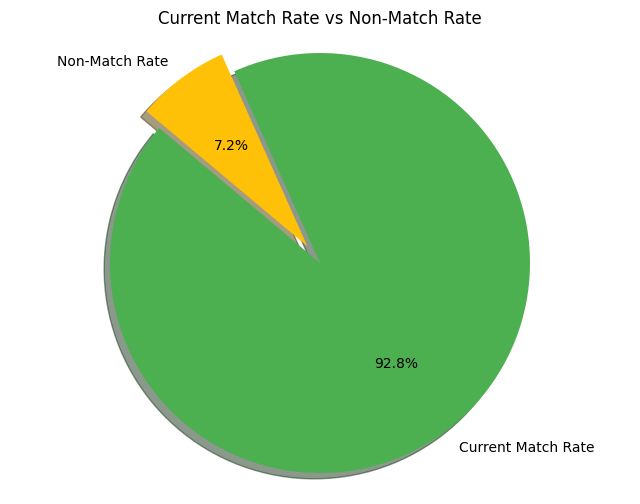

In [25]:

current_non_match_rate = 100 - current_match_rate

# Data for pie chart
labels = ['Current Match Rate', 'Non-Match Rate']
sizes = [current_match_rate, current_non_match_rate]
colors = ['#4CAF50', '#FFC107']  # Green and Amber colors for better visualization
explode = (0.1, 0)  # explode the 1st slice
# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Current Match Rate vs Non-Match Rate')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()
